## Introduction

This project replicates the counterfactual part of Multidimensional Auctions of Contracts: An Empirical Analysis by Yunmi Kong, Isabelle Perrigne, and Quang Vuong published in American Economics Review in 2022. This paper analyzes cash-royalty auctions of Louisiana oil leases. In this auction, the bidders bid for a one-time cash payment and royalty (the proportion of revenues they will pay the government afterward). The winner of the auction has the right of drilling, but it is not compulsory. They model this auction as a private value auction in which each bidder draws a private productivity level $\theta_1$ and a private cost $\theta_2$ of drilling $ from a joint distribution. The private value also depends on the oil price, which is modeled as a geometric Brownian motion. I will include more details of their auction model in this notebook.

This paper estimates the joint distribution of $\theta_1$ and $\theta_2$ non-parametrically and analyzes counterfactuals based on that. In this exercise, I replicate the main idea of this paper. First, I simulate $\theta_1$ and $\theta_2$ and compute the private values and bids for each firm. Then, I estimate the government choice probability of the auction winner from data. Lastly, I generate the Gaussian Copula from the data, which is important for estimating ex-ante probability of winning. 

In this exercise, I will show the following techniques that is helpful for future research.
1. autograd (one of the most important packages for deep learning, also important for optimization in economics)
2. copulas
3. sieve maximum likelihood estimation
4. optimization



In [1]:
try:
    from copulas.multivariate import GaussianMultivariate
except:
    %pip install copulas
    from copulas.multivariate import GaussianMultivariate

try:
    import autograd.numpy as np  # Thinly-wrapped numpy
    from autograd import grad    # The only autograd function you may ever need
    from autograd.scipy.stats import norm, chi2
except:
    %pip install autograd
    import autograd.numpy as np  # Thinly-wrapped numpy
    from autograd import grad    # The only autograd function you may ever need
    from autograd.scipy.stats import norm, chi2

import pandas as pd
import matplotlib.pyplot as plt
from turtle import color
import math
from sklearn.preprocessing import QuantileTransformer
from scipy.optimize import minimize, fsolve
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Monte Carlo Simulation
### Generate Fake Parameters

In [2]:
numB = 1000     # number of bidders
numA = 100     # number of auctions

THETA1 =  np.maximum(0.1, np.exp(np.random.normal(size=numB)))

# when THETA2 is standard normal times 12, the mean of THETA2/THETA1 is close to 21
#   the is the average cost per barrel.
THETA2 =  12 * np.minimum(10,np.exp(np.random.normal(scale=0.5, size=numB)))

Discriptive Statistics of the Fake Parameters. $\theta_1 / \theta_2$ is the average cost per barrel.

Text(0, 0.5, 'Density')

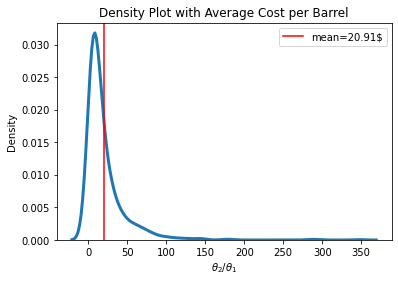

In [3]:
from turtle import color
from matplotlib.pyplot import xlabel
sns.distplot(THETA2/THETA1, hist = False, kde = True, kde_kws = {'linewidth': 3})
plt.axvline(x=np.mean(THETA2/THETA1),color='red', label='mean=' + str(round(np.mean(THETA2/THETA1),2)) + '$')
plt.legend(loc="upper right")
plt.title('Density Plot with Average Cost per Barrel')
plt.xlabel(r'$\theta_2 / \theta_1$')
plt.ylabel('Density')

### Compute the Private Values of Bidders

Let $a \in[0,1)$ be the royalty component of the bid, $\theta_1$ the firm's expected production volume, and $\theta_2$ the firm's economic cost of production, $t$ the duration in years until the lease expires, $p$ the price of oil at the time of the auction, $\sigma$ the price volatility, $r$ the one-year interest rate, and $\Phi(\cdot)$ the standard normal distribution. The oil price $p$ follows a geometric Brownian motion with volatility $\sigma$ and zero drift after adjusting for inflation. The variables $t, p, \sigma$, and $r$ are exogenous. Upon production, the firm receives the price at the time of production. A bidder's value for the lease at the time of auction is

$$V\left(a ; \theta_1, \theta_2\right)=e^{-r t}[\underbrace{(1-a) p \theta_1}_{\text {firm's share }} \Phi(x)-\theta_2 \underbrace{\Phi(x-\sigma \sqrt{t})}_{\operatorname{Pr}(\text { exercise })}]$$

where
$$x \equiv \frac{\log \left((1-a) p \theta_1 / \theta_2\right)+\sigma^2 t / 2}{\sigma \sqrt{t}}$$

In [4]:
def V(params):
    theta1, theta2, r, t, p, sigma, a = params
    x = (np.log((1-a) * p * theta1/theta2) + sigma**2 * t / 2) / (sigma * np.sqrt(t))
    v = np.exp(-r*t) * ( (1-a)*p*theta1*norm.cdf(x) + sigma**2 * t / 2 - theta2*norm.cdf(x - sigma * np.sqrt(t)))
    return v


# gradient by autograd    
grad_V = grad(V)

Plot the value against royalty

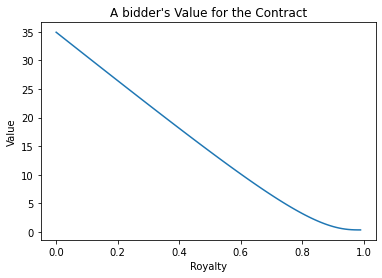

In [5]:
theta1 = 0.5
theta2 = 10
r = 0.05
t = 3
p = 100
sigma=0.5

def v(a):
    params = np.array([theta1, theta2, r, t, p, sigma, a])
    return V(params)

def grad_v(a):
    params = np.array([theta1, theta2, r, t, p, sigma, a])
    return grad_V(params)

agrids = np.arange(0, 1, 0.01)
values = [v(a) for a in agrids]
plt.title('A bidder\'s Value for the Contract')
plt.xlabel('Royalty')
plt.ylabel('Value')
plt.plot(agrids, values)

The Gradient of the value on royalty

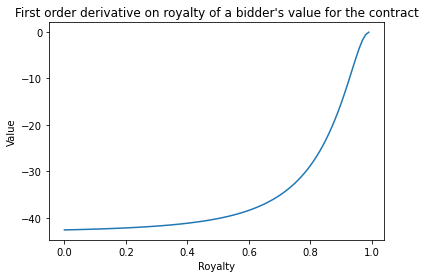

In [6]:
agrids = np.arange(0, 1, 0.01)
values = [grad_v(a)[-1] for a in agrids]
plt.title('First order derivative on royalty of a bidder\'s value for the contract')
plt.xlabel('Royalty')
plt.ylabel('Value')
plt.plot(agrids, values)

## Estimation
### The government choice probability $P(a, b)$

Using sieve maximum likelihood to estimate the government choice probability between two pairs of bids. 

In [7]:
def nchoosek(n,r):
    f = math.factorial
    return f(n) // f(r) // f(n-r)

def bernstein_bases_univariate(x, nx) :
    # sample size
    try:
        numS = len(x)
    except:
        numS = 1
    B = np.empty([numS, nx+1])
    for p in range(nx + 1):
        B[:,p] = ( nchoosek(nx,p)* x ** p ) * ((1-x) ** (nx-p)) 
    return B

def bernstein_bases_trivariate(x, y, z, nx, ny, nz) :
    '''
    Generate the bernstein bases from data
    '''
    
    # sample size
    try:
        numS = len(x)
    except:
        numS = 1

    Bx = bernstein_bases_univariate( x, nx )
    By = bernstein_bases_univariate( y, ny )
    Bz = bernstein_bases_univariate( z, nz )

    Bxym  = np.zeros((numS, nx+1, ny+1))
    Bxy   = np.zeros((numS, (nx+1)*(ny+1)))
    Bxyzm = np.zeros((numS, (nx+1)*(ny+1), nz+1))
    Bxyz  = np.zeros((numS, (nx+1)*(ny+1)*(nz+1)))

    for i in range(numS):
        Bxym[i,:,:] = np.outer(Bx[i,:], By[i,:])

    for i in range(numS):
        Bxy[i,:] = Bxym[i,:,:].flatten()
    
    for i in range(numS):
        Bxyzm[i,:,:] = np.outer(Bxy[i,:], Bz[i,:])

    for i in range(numS):
        Bxyz[i,:] = Bxyzm[i,:,:].flatten()

    return Bxyz

def gchoice_L(beta) :
    '''
    Log likelihood function
    '''
    P = bases @ beta
    P = np.maximum(0.000001, P)
    P = np.minimum(0.99999, P)
    L = np.sum(win * np.log(P) + (1-win) * np.log(1-P))
    return -L

def gchoice_fun(dcn, drn, index = 0.5):
    '''
    Probibility of winning
    '''
    return (bernstein_bases_trivariate(dcn, drn, index, nx, ny, nz) @ beta)[0]

#### Read Data

variables are 

win     - winning dummy

diffr   - difference between the winning roylty bid and the losing royalty bid

lndiffc - difference between log of the winning cash bid and the losing cash bid

index   - an index that summerize all other coviariate (the charateristic of the lease)

In [8]:
filename = 'Data_for_gchoice.csv';
GOV = pd.read_csv(filename)
GOV_SUB = GOV[['win', 'diffr', 'lndiffc', 'index']]
GOV_SUB.head(5)

,win,diffr,lndiffc,index
0,0,-0.033333,0.105675,0.296
1,1,0.033333,-0.105675,0.296
2,0,-0.033333,0.043064,0.200
3,1,0.033333,-0.043064,0.200
4,0,0.000000,-0.082144,0.878


#### Sieve MLE

In [9]:
qt = QuantileTransformer()

GOV_X = GOV_SUB[['diffr', 'lndiffc']]
# standization of the data
GOV_STD = qt.fit_transform(GOV_X)

x = GOV_STD[:,0]
y = GOV_STD[:,1]
z = GOV['index'].array.to_numpy()

win = GOV.win.array.to_numpy()

# orders of the seive estimation bernstein polynomial
nx = 6
ny = 6
nz = 2

# generate the bernstein bases from data
bases = bernstein_bases_trivariate(x, y, z, nx, ny, nz)

# sample size
numS = bases.shape[0]

# gradient by autograd
grad_gchoice_L = grad(gchoice_L)

# initial guesses
init = tuple([0.5]*147)

# mle
result = minimize(gchoice_L, init, method='SLSQP', bounds=[(0,1)]*147, jac=grad_gchoice_L)

# get estimated parameters for the bernstein polynomial if the optimization succeeded 
beta = result.x if result.success else np.nan

result.success

True

#### Plot

This is the figure 3 in the original paper.

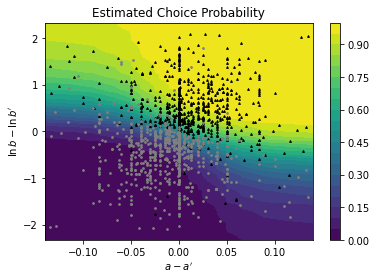

In [10]:
numGRID = 100

a_qt = np.linspace(0.01, 0.99, numGRID)
b_qt = np.linspace(0.01, 0.99, numGRID)
A_qt, B_qt = np.meshgrid(a_qt, b_qt)

f = np.frompyfunc(gchoice_fun, 2, 1)
P = f(A_qt, B_qt)

# The bids were standadized to quantiles, now we need to transform it back to actual bids
a = qt.inverse_transform(np.vstack((a_qt, b_qt)).T)[:,0]
b = qt.inverse_transform(np.vstack((a_qt, b_qt)).T)[:,1]
A, B = np.meshgrid(a, b)

im = plt.contourf(A, B, P, 20, cmap='viridis')
plt.colorbar(im)
GOV_PLOT = GOV_SUB[ (GOV_SUB['diffr'] < 0.14) & (GOV_SUB['diffr'] > -0.14) & (GOV_SUB['lndiffc'] < 2.1) & (GOV_SUB['lndiffc'] > -2.1)]
GOV_PLOT_WIN  = GOV_PLOT[GOV_PLOT['win'] == 1]
GOV_PLOT_LOSS = GOV_PLOT[GOV_PLOT['win'] == 0]
plt.scatter(GOV_PLOT_WIN.diffr,GOV_PLOT_WIN.lndiffc,c ="black", marker='^', s=3)
plt.scatter(GOV_PLOT_LOSS.diffr,GOV_PLOT_LOSS.lndiffc,c ="grey", marker='o', s=3)
plt.xlabel(r'$a - a^\prime$')
plt.ylabel(r'$\ln b - \ln b^\prime$')
plt.title('Estimated Choice Probability')
plt.show()


### Sample from joint density of two 2-D bids
We simulate more data from the original dataset. by copula. Marginal densities are estimated via kernels and affiliation is estimated via Gaussian copula. In Python, this can be done easily with GaussianMultivariate class in copulas.multivariate package.

In [11]:
BIDS = pd.read_csv('Data_for_kdensity.csv')
BIDS

,roy_dm,lncpad_dm,accbid
0,0.012741,-0.142119,1
1,-0.020593,-0.036445,0
2,0.008937,0.055362,1
3,-0.024396,0.098425,0
4,-0.001684,1.158188,1
...,...,...,...
899,-0.051214,-0.321059,0
900,0.022731,-0.501388,0
901,0.022731,-0.180459,1
902,-0.031481,0.437533,1


Sample is the true dataset where (a, b) are winning bids and (a0, b0) are the corresponding losing bid.

In [12]:
BIDS_WIN   = BIDS[BIDS['accbid'] == 1].reset_index().drop(columns=['index', 'accbid']).rename(columns={'roy_dm' : 'a', 'lncpad_dm' : 'b'})
BIDS_LOSS  = BIDS[BIDS['accbid'] == 0].reset_index().drop(columns=['index', 'accbid']).rename(columns={'roy_dm' : 'a0', 'lncpad_dm' : 'b0'})
SAMPLE = pd.concat([BIDS_WIN, BIDS_LOSS], axis=1)
SAMPLE

,a,b,a0,b0
0,0.012741,-0.142119,-0.020593,-0.036445
1,0.008937,0.055362,-0.024396,0.098425
2,-0.001684,1.158188,0.218316,-0.525739
3,-0.000209,1.693100,0.083125,0.991736
4,-0.026788,0.605619,-0.026788,0.241175
...,...,...,...,...
447,0.017153,1.314598,0.042153,0.649905
448,0.006287,-0.188547,0.006287,-0.792542
449,-0.021214,-0.666975,-0.051214,-0.321059
450,0.022731,-0.180459,0.022731,-0.501388


SYNTHETIC is the simulated data which contains 5000 samples. 

In [13]:
model = GaussianMultivariate()
SYNTHETIC = model.fit(SAMPLE)
SYNTHETIC = model.sample(5000)
SYNTHETIC

,a,b,a0,b0
0,-0.011933,1.296021,0.022030,1.074831
1,-0.017054,0.502678,-0.007523,0.187998
2,-0.024184,0.253789,-0.063426,-0.525882
3,0.024299,0.600718,0.008325,0.042624
4,-0.025112,-0.388160,-0.055961,-0.162182
...,...,...,...,...
4995,0.001770,0.914571,0.026263,0.231361
4996,-0.043999,-0.015241,-0.032302,-0.700983
4997,0.005892,0.403338,-0.011091,0.219268
4998,-0.027403,1.025351,0.022597,0.152808


## Compute the Optimal Cash-Royalty Bidding

Given his type $\left(\theta_{1 i}, \theta_{2 i}\right)$, bidder $i$ chooses his bid $\left(a_i, b_i\right)$ to maximize his expected utility from the auction given his winning probability $P\left(\cdot, \cdot \mid \theta_{1 i}, \theta_{2 i}, n\right)$. His maximization problem is 
\begin{equation*}
\max _{a, b}\left[V\left(a ; \theta_{1 i}, \theta_{2 i}\right)-b\right] P\left(a, b \mid \theta_{1 i}, \theta_{2 i}, n\right)
\end{equation*}

We now omit the index $i$ for sake of simplicity. Differentiating with respect to $a$ and $b$, the first-order conditions give
$$
\begin{gathered}
V_a\left(a ; \theta_1, \theta_2\right)=-\frac{P_a\left(a, b \mid \theta_1, \theta_2, n\right)}{P_b\left(a, b \mid \theta_1, \theta_2, n\right)}, \\
V\left(a ; \theta_1, \theta_2\right)=b+\frac{P\left(a, b \mid \theta_1, \theta_2, n\right)}{P_b\left(a, b \mid \theta_1, \theta_2, n\right)} .
\end{gathered}
$$


#### A toy model (Best Response under Independent Private Values + Common Knowledge of the Rival Type)
I first consider the independent private values (IPV) case. I assume that $(\theta_{1i}, \theta_{2i})$ are i.i.d aross $i$. Nothe that this is different from the affliated private values (APV) model used by the original paper. APV allows correlation between $(\theta_{1i}, \theta_{2i})$ across samples. This paper finds high correlations between bidders (0.81 for production and 0.90 for cost), suggesting that APV is a better assumption.


The IPV assumption implies that the $P\left(\cdot, \cdot \mid \theta_{1}, \theta_{2}, n\right) = P\left(\cdot, \cdot \mid n\right)$, and $n = 2$ for each auction. The common knowledge assumptiion implies that each bidder knows the best response function of their rivals.

In [14]:
# the type of the bider
theta1 = 192.75
theta2 = 2737

# exogenous variables
r = 0.05
t = 3
p = 100
sigma=0.5


def bidder_value(a, b):

    def v(a):
        params = np.array([theta1, theta2, r, t, p, sigma, a])
        return V(params)

    def grad_v(a):
        params = np.array([theta1, theta2, r, t, p, sigma, a])
        return grad_V(params)

    def gchoice(a, b):
        lnb = np.log(b)
        lnb0 = np.log(b0)
        diffa = a - a0
        diffb = lnb - lnb0
        dcn = qt.transform(np.array([diffa, diffb]).reshape(1,2))[:,0]
        drn = qt.transform(np.array([diffa, diffb]).reshape(1,2))[:,1]
        return gchoice_fun(dcn, drn, index = 0.5)

    # numerical derivative
    def grad_gchoice(a, b):
        gap = 0.000001
        grad_a = ( gchoice(a+gap, b) - gchoice(a-gap, b) ) / (2*gap)
        grad_b = ( gchoice(a, b+gap) - gchoice(a, b-gap) ) / (2*gap)
        return np.array([grad_a, grad_b])

    def bidder_foc(p):
        a, b = p
        foc_a = grad_v(a)[-1] + grad_gchoice(a, b)[0] / grad_gchoice(a, b)[1]
        foc_b = v(a) - b - gchoice(a, b) / grad_gchoice(a, b)[1]
        return foc_a ** 2 + foc_b ** 2

    params = [theta1, theta2, r, t, p, sigma, a]
    return (V(params) - b) * gchoice(a, b)


The following figure shows that if the rival bid 0.2 royalty and 100000 cash. The best response is to bid approximately 0.3 royalty and nearly no cash.

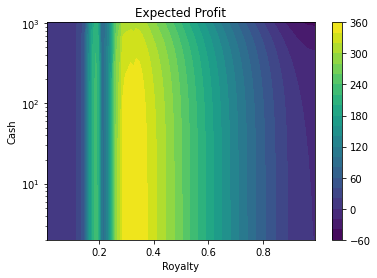

In [15]:
# fix the bid pair of the rival
a0 = 0.2
b0 = 100000

a_ = np.linspace(0.01, 0.99, numGRID)
b_ = 2 ** np.linspace(1, 10, numGRID)
A_, B_ = np.meshgrid(a_, b_)
f = np.frompyfunc(bidder_value, 2, 1)
VALUES = f(A_, B_)

plt.yscale("log")
im = plt.contourf(A_, B_, VALUES, 20, cmap='viridis')
plt.colorbar(im)

plt.xlabel('Royalty')
plt.ylabel('Cash')
plt.title('Expected Profit')
plt.show()

The out-bid-royalty strategy presists even if the rival increase its royalty bid to 0.5. In these cases, the probability of drilling is low, making the government lose profit.

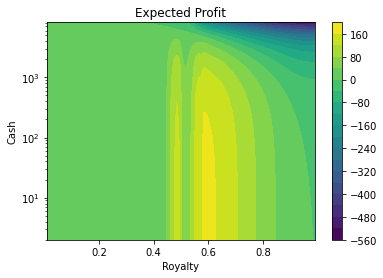

In [16]:
# fix the bid pair of the rival
a0 = 0.5
b0 = 100000

a_ = np.linspace(0.01, 0.99, numGRID)
b_ = 2 ** np.linspace(1, 13, numGRID)
A_, B_ = np.meshgrid(a_, b_)
f = np.frompyfunc(bidder_value, 2, 1)
VALUES = f(A_, B_)

plt.yscale("log")
im = plt.contourf(A_, B_, VALUES, 20, cmap='viridis')
plt.colorbar(im)

plt.xlabel('Royalty')
plt.ylabel('Cash')
plt.title('Expected Profit')
plt.show()

The previous two cases are unlikely to be an equilibrium, since it is not rational for the rival to bid such a high $b$. The following example is pobability how the equilibrium might look like: when the rival bid $(0.2, 10000)$, the best response is to bid around $(0.25, 8000)$.

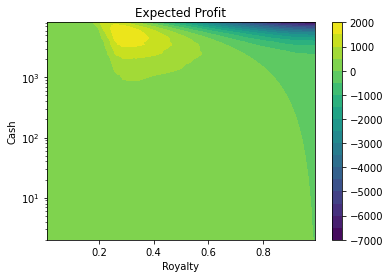

In [17]:
# fix the bid pair of the rival
a0 = 0.2
b0 = 10000

a_ = np.linspace(0.01, 0.99, numGRID)
b_ = 2 ** np.linspace(1, 13, numGRID)
A_, B_ = np.meshgrid(a_, b_)
f = np.frompyfunc(bidder_value, 2, 1)
VALUES = f(A_, B_)

plt.yscale("log")
im = plt.contourf(A_, B_, VALUES, 20, cmap='viridis')
plt.colorbar(im)

plt.xlabel('Royalty')
plt.ylabel('Cash')
plt.title('Expected Profit')
plt.show()

## Limitation

1. The original paper estimates the ex-ante probability of winning from integrating the ex-post government choice probability on the distribution of the rival bids conditional on one's type. I didn't exploit this game theoretical setting, but just use copula to replicate the data set that they used for the estimation. The entire estimation takes much longer time. 

2. I did not impose the monotonicity constrains on the government choice probability estimation. The monotonicity conditions are important for a unique solution of the FOC of bidding strategy. However, even without these conditions, figure 3 is very close to the original paper, suggesting that these conditions are weak.

Imposing monotonicity constrain for Bernstein Polynomials are easy. Linear constrains of parameters will do. 


3. Before estimating the government choice probability, I transformed the data to quantiles. Thus, to compute the 
government choice probability from user specified bids, I need to transform the bids to quantiles. However, I couldn't get the formula from $\texttt{QuantileTransformer()}$. Therefore, I couldn't use $\texttt{autograd}$ to compute $P_a\left(a, b \mid \theta_1, \theta_2, n\right)$ etc., making it hard to get stable optimal bids from the FOC of bidding strategy (the numerical derivatives is not performing as well as autograd). 

